In [70]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import operator
from math import floor,ceil
import tensorflow as tf
print(tf.__version__)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pytesseract
from keras.models import model_from_json

2.1.0


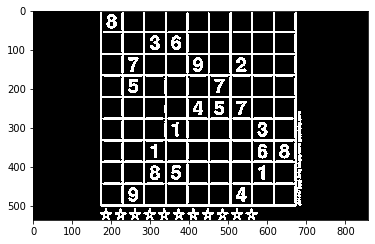

In [2]:
def proc_img(img):
    img1 = cv.GaussianBlur(img.copy(), (9, 9), 0)
    img1 = cv.adaptiveThreshold(img1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    img1 = cv.bitwise_not(img1, img1)
    kernel = np.array([[0., 1., 0.], [1., 1., 1.], [0., 1., 0.]], np.uint8)
    img1 = cv.dilate(img1, kernel)
    return img1

img = cv.imread('sudoku2.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
plt.imshow(processed,'gray')

In [3]:
def show_img(img):
	cv.imshow('image', img)
	cv.waitKey(0)
	cv.destroyAllWindows()

In [4]:
def display_points(img, points, radius=5, colour=(0, 0, 255)):
    img = img.copy()
    if len(colour) == 3:
        if len(img.shape) == 2:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
        elif img.shape[2] == 1:
            img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    for point in points:
        img = cv.circle(img, tuple(int(x) for x in point), radius, colour, -1)
    show_img(img)

In [5]:
def grid(img):
    contours, _ = cv.findContours(img.copy(), cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key=cv.contourArea, reverse=True)
    cnt = contours[0]
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in cnt]), key=operator.itemgetter(1))
    return [cnt[top_left][0], cnt[top_right][0], cnt[bottom_right][0], cnt[bottom_left][0]]

img = cv.imread('sudoku1.png', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
print(corners)
display_points(processed, corners)

[array([ 46, 143], dtype=int32), array([381, 146], dtype=int32), array([380, 478], dtype=int32), array([ 44, 478], dtype=int32)]


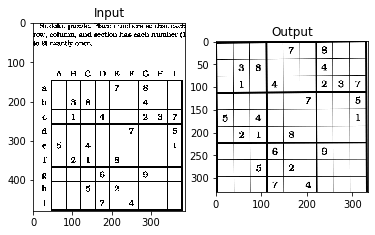

In [6]:
def perspect(img,corners):
    rows,cols = img.shape
    h = corners[1][0] - corners[0][0]
    w = corners[2][1] - corners[1][1]
    pts1 = np.float32([corners[0],corners[1],corners[3],corners[2]])
    #pts1 = np.float32([[x,y],[x+w,y],[x,y+h],[x+w,y+h]])
    pts2 = np.float32([[0,0],[w,0],[0,h],[w,h]])
    M = cv.getPerspectiveTransform(pts1,pts2)
    dst = cv.warpPerspective(img,M,(h,w))
    show_img(dst)
    plt.subplot(121),plt.imshow(img,'gray'),plt.title('Input')
    plt.subplot(122),plt.imshow(dst,'gray'),plt.title('Output')
    return dst

img = cv.imread('sudoku1.png', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)

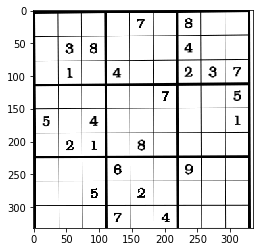

In [7]:
plt.imshow(img_final,'gray')

In [ ]:
row , col = img.shape
rowp = row/9
colp = col/9
i=1
j=2
pts1 = np.float32([[i*1.05*rowp,j*(1.05*colp)],[(i+1)*0.95*rowp,j*1.05*colp],[i*1.05*rowp,(j+1)*0.95*colp],[(i+1)*0.95*rowp,(j+1)*0.95*colp]])
#pts1 = np.float32([[x,y],[x+w,y],[x,y+h],[x+w,y+h]])
pts2 = np.float32([[0,0],[0.9*rowp,0],[0,0.9*colp],[0.9*rowp,0.9*colp]])
M = cv.getPerspectiveTransform(pts1,pts2)
dst = cv.warpPerspective(img_final,M,(ceil(0.9*rowp),ceil(0.9*colp)))
plt.subplot(121),plt.imshow(img_final,'gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst,'gray'),plt.title('Output')

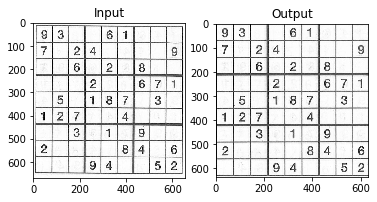

In [189]:
def extract_grid(img):
    row, col = img.shape
    rowp = row/9
    colp = col/9
    imgp = []
    dim = (floor(rowp),floor(colp))
    for j in range(9):
        for i in range(9):
            pts1 = np.float32([[i*1.025*rowp,j*1.025*colp],[(i+1)*0.975*rowp,j*1.025*colp],[i*1.025*rowp,(j+1)*0.975*colp],[(i+1)*0.975*rowp,(j+1)*0.975*colp]])
            pts2 = np.float32([[0,0],[rowp,0],[0,colp],[rowp,colp]])
            M = cv.getPerspectiveTransform(pts1,pts2)
            dst = cv.warpPerspective(img,M,dim)
            imgp.append(dst)
    return imgp

img = cv.imread('sudoku48.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)
imgp = extract_grid(img_final)

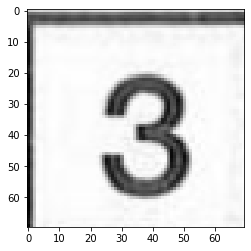

In [191]:
plt.imshow(imgp[1],'gray')

1


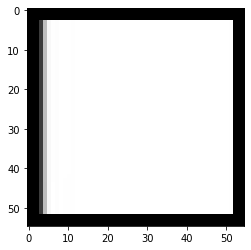

In [11]:
#imgray = cv.cvtColor(imgp[10], cv.COLOR_BGR2GRAY)
#thresh = cv.adaptiveThreshold(imgp[10],255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,cv.THRESH_BINARY,11,2)
contours, hierarchy = cv.findContours(imgp[8], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
temp = cv.drawContours(imgp[8].copy(), contours, 0, (0,255,0), 3)
plt.imshow(temp,'gray')
print(len(contours))

In [85]:
def load_ocr_data(path):
    # get a list of all the images
    imlist = [os.path.join(path,f) for f in os.listdir(path)]
    # create labels
    labels = [int(imfile.split('/')[-1][0]) for imfile in imlist]

    # create features from the images
    features = []
    for imname in imlist:
        '''im = array(Image.open(imname).convert('L'))
        features.append(compute_feature(im))'''
        im = cv.imread(imname,cv.IMREAD_GRAYSCALE)
        im = cv.medianBlur(im.copy(), 5)
        im = cv.adaptiveThreshold(im, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
        im = cv.bitwise_not(im, im)
        features.append(im)
    return features,labels

In [86]:
features,labels = load_ocr_data('ocr_data/training/')
features = np.asarray(features)
labels = np.asarray(labels)
print(labels)

[0 0 0 ... 9 9 9]


In [180]:
print(features[0].shape)
x_train = []
for f in features:
    resized = cv.resize(f, (50,50), interpolation = cv.INTER_AREA) 
    x_train.append(resized)
    

x_train = np.asarray(x_train)

x_train = x_train.reshape(x_train.shape[0], 50, 50, 1)

#features = features.reshape(1409, 80, 80, 1)
#x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)
#print(x_train[1].shape)
#input_shape = (28, 28, 1)
# Making sure that the values are float so that we can get decimal points after division
x_train = x_train.astype('float32')
#x_test = x_test.astype('float32')
# Normalizing the RGB codes by dividing it to the max RGB value.
x_train /= 255
#x_test /= 255
print(len(x_train))

(80, 81)
6353


In [88]:
'''model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.2))
model.add(Dense(10,activation=tf.nn.softmax))'''
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), input_shape=(50,50,1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(16, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))


In [89]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])
model.fit(x=x_train,y=labels, epochs=10)

Epoch 1/10
6353/6353 [==============================] - 4s 668us/step - loss: 0.9120 - accuracy: 0.7170
Epoch 2/10
6353/6353 [==============================] - 4s 657us/step - loss: 0.2826 - accuracy: 0.9144
Epoch 3/10
6353/6353 [==============================] - 4s 680us/step - loss: 0.1475 - accuracy: 0.9555
Epoch 4/10
6353/6353 [==============================] - 4s 704us/step - loss: 0.0876 - accuracy: 0.9748
Epoch 5/10
6353/6353 [==============================] - 4s 657us/step - loss: 0.0523 - accuracy: 0.9847
Epoch 6/10
6353/6353 [==============================] - 4s 661us/step - loss: 0.0384 - accuracy: 0.9895
Epoch 7/10
6353/6353 [==============================] - 4s 695us/step - loss: 0.0229 - accuracy: 0.9928
Epoch 8/10
6353/6353 [==============================] - 5s 728us/step - loss: 0.0253 - accuracy: 0.9923
Epoch 9/10
6353/6353 [==============================] - 5s 732us/step - loss: 0.0226 - accuracy: 0.9928
Epoch 10/10
6353/6353 [==============================] - 5s 730u

(50, 50)
[[1.25938118e-06 6.73367282e-08 2.56005023e-07 3.62963229e-03
  6.90883389e-05 4.68982398e-06 7.31572470e-07 2.26555455e-10
  1.13716495e-04 9.96180534e-01]]
9


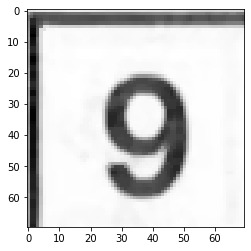

In [178]:
temp = np.asarray(imgp)
#print(temp[3].shape
temp1 = cv.medianBlur(temp[0].copy(), 3)
temp_p = temp1.copy()
temp1 = cv.adaptiveThreshold(temp1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
temp1 = cv.bitwise_not(temp1, temp1)
temp1 = cv.resize(temp1, (50,50), interpolation = cv.INTER_AREA) 
plt.imshow(temp_p,'gray')
print(temp1.shape)
temp1 = temp1.reshape(1,50,50, 1)
temp1 = temp1.astype('float32')
temp1 /= 255
predict = model.predict(temp1)
print(predict)
print(np.argmax(predict))
#temp2 = cv.cvtColor(temp[5],cv.COLOR_GRAY2RGB)
#pred = pytesseract.image_to_string(temp2, lang='eng',config='--psm 10 --oem 3 -c tessedit_char_whitelist=0123456789')
#print(pred)

In [181]:
model.save('model.h5')

In [184]:
new_model = tf.keras.models.load_model('model.h5')


In [194]:
def identify_digit(box):
    temp1 = cv.medianBlur(box.copy(), 3)
    temp1 = cv.adaptiveThreshold(temp1, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    temp1 = cv.bitwise_not(temp1, temp1)
    temp1 = cv.resize(temp1, (50,50), interpolation = cv.INTER_AREA)
    temp1 = temp1.reshape(1,50,50, 1)
    temp1 = temp1.astype('float32')
    temp1 /= 255
    predict = model.predict(temp1)
    return(np.argmax(predict))

In [197]:
def extract_digit(imgp):
    sudoku = []
    temp = []
    for i in range(0,81):
        num = identify_digit(imgp[i])
        temp.append(num)
        if((i+1)%9 == 0):
            sudoku.append(temp.copy())
            temp = []
    
    return sudoku

[[9, 3, 0, 0, 6, 1, 0, 0, 0], [7, 0, 2, 4, 0, 0, 0, 0, 9], [0, 0, 6, 0, 2, 0, 8, 0, 0], [0, 0, 0, 2, 0, 0, 6, 7, 1], [0, 5, 0, 1, 8, 7, 0, 3, 0], [1, 2, 7, 0, 0, 4, 0, 0, 0], [0, 0, 3, 0, 1, 0, 9, 0, 0], [2, 0, 0, 0, 0, 8, 4, 0, 6], [0, 0, 0, 9, 4, 0, 0, 5, 2]]


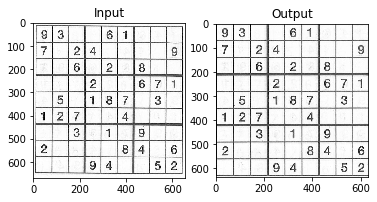

In [220]:
img = cv.imread('sudoku48.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)
imgp = extract_grid(img_final)
sudoku = extract_digit(imgp)
print(sudoku)

In [227]:
def print_grid(arr): 
    for i in range(9): 
        for j in range(9): 
            print (arr[i][j])
        print ('\n') 
        
def find_empty_location(arr,l): 
    for row in range(9): 
        for col in range(9): 
            if(arr[row][col]==0): 
                l[0]=row 
                l[1]=col 
                return True
    return False
 
def used_in_row(arr,row,num): 
    for i in range(9): 
        if(arr[row][i] == num): 
            return True
    return False
 
def used_in_col(arr,col,num): 
    for i in range(9): 
        if(arr[i][col] == num): 
            return True
    return False

def used_in_box(arr,row,col,num): 
    for i in range(3): 
        for j in range(3): 
            if(arr[i+row][j+col] == num): 
                return True
    return False
 
def check_location_is_safe(arr,row,col,num): 
    return not used_in_row(arr,row,num) and not used_in_col(arr,col,num) and not used_in_box(arr,row - row%3,col - col%3,num) 
 
def solve_sudoku(arr): 
    l=[0,0] 
    if(not find_empty_location(arr,l)): 
        return True
    row=l[0] 
    col=l[1] 
    for num in range(1,10): 
        if(check_location_is_safe(arr,row,col,num)):  
            arr[row][col]=num  
            if(solve_sudoku(arr)): 
                return True 
            arr[row][col] = 0
    return False
 
def sudoku_solver(grid1):
    sudoku = []
    for l in grid1:
        sudoku.append(l.copy())
    if(solve_sudoku(sudoku)):
        print('---')
    else:
        print ("No solution exists")
    return sudoku    

In [229]:
print(sudoku)

sudoku_solver(sudoku)

[[9, 3, 0, 0, 6, 1, 0, 0, 0], [7, 0, 2, 4, 0, 0, 0, 0, 9], [0, 0, 6, 0, 2, 0, 8, 0, 0], [0, 0, 0, 2, 0, 0, 6, 7, 1], [0, 5, 0, 1, 8, 7, 0, 3, 0], [1, 2, 7, 0, 0, 4, 0, 0, 0], [0, 0, 3, 0, 1, 0, 9, 0, 0], [2, 0, 0, 0, 0, 8, 4, 0, 6], [0, 0, 0, 9, 4, 0, 0, 5, 2]]
---


[[9, 3, 4, 8, 6, 1, 7, 2, 5],
 [7, 8, 2, 4, 5, 3, 1, 6, 9],
 [5, 1, 6, 7, 2, 9, 8, 4, 3],
 [3, 4, 8, 2, 9, 5, 6, 7, 1],
 [6, 5, 9, 1, 8, 7, 2, 3, 4],
 [1, 2, 7, 6, 3, 4, 5, 9, 8],
 [4, 6, 3, 5, 1, 2, 9, 8, 7],
 [2, 9, 5, 3, 7, 8, 4, 1, 6],
 [8, 7, 1, 9, 4, 6, 3, 5, 2]]

[[9, 3, 0, 0, 6, 1, 0, 0, 0], [7, 0, 2, 4, 0, 0, 0, 0, 9], [0, 0, 6, 0, 2, 0, 8, 0, 0], [0, 0, 0, 2, 0, 0, 6, 7, 1], [0, 5, 0, 1, 8, 7, 0, 3, 0], [1, 2, 7, 0, 0, 4, 0, 0, 0], [0, 0, 3, 0, 1, 0, 9, 0, 0], [2, 0, 0, 0, 0, 8, 4, 0, 6], [0, 0, 0, 9, 4, 0, 0, 5, 2]]
---


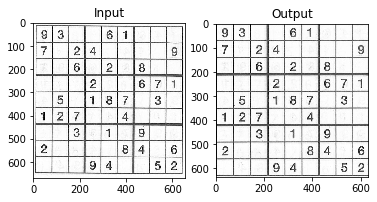

In [231]:
img = cv.imread('sudoku48.jpg', cv.IMREAD_GRAYSCALE)
processed = proc_img(img)
corners = grid(processed)
img_final = perspect(img,corners)
imgp = extract_grid(img_final)
sudoku = extract_digit(imgp)
print(sudoku)
solved = sudoku_solver(sudoku)

In [306]:
def impose(solved, sudoku, img):
    img = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
    row , col , _ = img.shape
    rowp , colp = row/9, col/9
    for i in range(9):
        for j in range(9):
            if(sudoku[i][j] == 0):
                x = floor((i+1) * rowp)
                y = floor((j) * colp * 1.8)
                cv.putText(img,str(solved[i][j]),(y,x),cv.FONT_HERSHEY_PLAIN,4,(255,0,0),5)
    return img

In [297]:
def solve_complete(PATH):
    img = cv.imread(PATH, cv.IMREAD_GRAYSCALE)
    processed = proc_img(img)
    corners = grid(processed)
    img_final = perspect(img,corners)
    imgp = extract_grid(img_final)
    sudoku = extract_digit(imgp)
    print(sudoku)
    solved = sudoku_solver(sudoku)
    print(solved)
    img_solved = impose(solved, sudoku, img)
    return img_solved

[[0, 0, 8, 0, 7, 0, 0, 5, 6], [3, 0, 0, 0, 6, 4, 0, 8, 0], [0, 0, 0, 3, 0, 8, 1, 9, 0], [0, 9, 3, 0, 0, 2, 0, 0, 8], [0, 0, 0, 6, 9, 7, 0, 0, 0], [1, 0, 0, 8, 0, 0, 4, 2, 0], [0, 4, 1, 7, 0, 3, 0, 0, 0], [0, 3, 0, 5, 8, 0, 0, 0, 1], [6, 2, 0, 0, 4, 0, 8, 0, 0]]
---
[[4, 1, 8, 2, 7, 9, 3, 5, 6], [3, 5, 9, 1, 6, 4, 7, 8, 2], [7, 6, 2, 3, 5, 8, 1, 9, 4], [5, 9, 3, 4, 1, 2, 6, 7, 8], [2, 8, 4, 6, 9, 7, 5, 1, 3], [1, 7, 6, 8, 3, 5, 4, 2, 9], [8, 4, 1, 7, 2, 3, 9, 6, 5], [9, 3, 7, 5, 8, 6, 2, 4, 1], [6, 2, 5, 9, 4, 1, 8, 3, 7]]


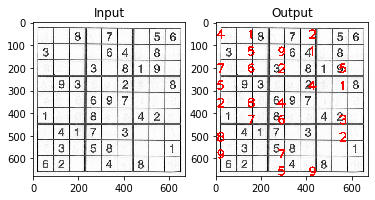

In [307]:
img = solve_complete('sudoku46.jpg')

plt.imshow(img)

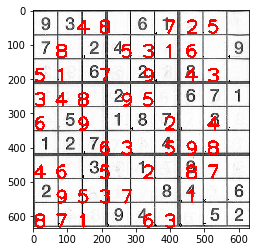

In [300]:
img_solved = impose(solved, sudoku, img_final)
plt.imshow(img_solved,'gray')